In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [2]:
list.files(path = ".")

[1] "data"           "scanpath.ipynb"

In [3]:
# pq <- read.csv("/kaggle/input/presence-questionnaire/presence_questionnaire.csv", comment.char="#")
pq <- read.csv("../presence_questionnaire.csv", comment.char=",")

In [4]:
list.files("./data")

[1] "100" "101" "102" "103" "104" "105" "106" "107" "108" "109" "110" "111"
[13] "112" "113" "114" "115" "116" "117" "118" "119" "120" "121" "122" "123"
[25] "124" "126" "127" "128" "129"

In [5]:
child_dirs <- list.files("./data")

character(0)

In [17]:
child_dir = child_dirs[1]
f <- list.files(paste0("./data/",child_dir))
file_path <- f[grep("\\.csv$", f)]
g <- paste0("./data/",child_dir,"/",file_path)

In [23]:
g

[1] "./data/100/1.17.2023_2.00.26_PM.csv"

In [19]:
getAllEntropies <- function(ntime,nstates){
  #this computes an array of entropies for each individual
  #ntime is the number of time divisions, noting that the sampling
  #rate for eye tracking is 50Hz
  #nstates is the number of divisions of the x-target into segments
  #covering the 360 degrees in front of the participant
  
  
  # List all child directories within the parent directory
  # child_dirs <- list.files("/kaggle/input/scanpath-data")
  child_dirs <- list.files("./data")
  #the rows are the participants and the columms the successive entropies
  allEntropy <- matrix(0,nrow=length(child_dirs),ncol=ntime)
  
  s <- seq(-pi,0,pi/nstates) #this divides the space in front (the x axis)
  s <- cos(s) #the x-coordinate
  ind <- 1 #which individual
  
  timelastchange <- vector() #time of last change of configuration
  #this stores the index into the segmented time period for the last change
  indexlastchange <- vector()
  
  # Loop over each child directory
  for (child_dir in child_dirs) {
    #cat(ind," ",child_dir,"\n")
    
    # Change the working directory to the child directory
    #setwd(child_dir)
    
    # Find the file path
    #f <- list.files()
    #f <- list.files(paste0("/kaggle/input/scanpath-data/",child_dir))
    f <- list.files(paste0("./data/",child_dir))
    file_path <- f[grep("\\.csv$", f)]

    # Check if the file exists in the child directory
    #g <- paste0("/kaggle/input/scanpath-data/",child_dir,"/",file_path)
    g <- paste0("./data/",child_dir,"/",file_path)
    if (file.exists(g)) {
      
      # Read the file 
      d <- read.csv(g) 
      x <- d$EyeTrackingTarget_X 
      m <- length(x)
      t <- round(seq(1,m,(m/ntime)))
      t[length(t)+1] <- m
      #intervals are t[i]:t[i+1], i=1,...,nseg-1
      for(j in 1:(length(t)-1)){
        allEntropy[ind,j] <- entropy(s,x[t[j]:t[j+1]])
      }
      
      lastchange <- lastChange(d)
      #actual time of the last change
      timelastchange[ind] <- d$Seconds[lastchange]- d$Seconds[1]
      #indexlastchange[ind] <- findInterval(timelastchange[ind],t) + 1
      indexlastchange[ind] <- findInterval(round(lastchange),t)
      
    } else {
      warning(paste("File", file_path, "does not exist in directory", child_dir))
    }
    
    # Change back to the parent directory
    ind = ind+1
    setwd("..")
  }
  #allEntropy <- allEntropy[,-ntime]
  return(list(allEntropy = allEntropy,timelastchange =timelastchange, indexlastchange=indexlastchange))
  
}

In [20]:
entropy <- function(states,x){
  #states is a sequence of intervals states[1], states[2] corresponding to segments 
  #on the target x axis dividing the scene in front.
  #x is a sequence of x values in the range -1 to 1 corresponding to observed
  #target eye movements
  
  #finds the frequency distribution of x by the segments s
  freq <- hist(x, breaks = states, plot = FALSE)
  p <- freq$counts/sum(freq$counts) #the probabilities
   
  return( -sum(ifelse(p == 0, 0, p * log2(p))) )

}

In [21]:
lastChange <- function(d){
  
  data_matrix <- cbind(d$Stereopsis, d[["6DoF"]], d$SpatialAudio, d$HighResolution, d$AltColour)
  
  # Convert each row to a binary number
  binary_numbers <- apply(data_matrix, 1, function(row) {
    sum(2^(which(rev(row) == 1) - 1))
  })
  
  # Find the index of the last change
  last_change_index <- max(which(c(TRUE, diff(binary_numbers) != 0)))
  
  return(last_change_index)
}

In [22]:
a <- getAllEntropies(30,18)

Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropies(30, 18):
Warning message in getAllEntropi

In [9]:
#note to plot the mean over all participants of entropies by time use
t <- seq(1,30)
et <- apply(a$allEntropy,2,mean)
cor.test(t,et)


	Pearson's product-moment correlation

data:  t and et
t = -0.045895, df = 28, p-value = 0.9637
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3677931  0.3526982
sample estimates:
         cor 
-0.008673093 


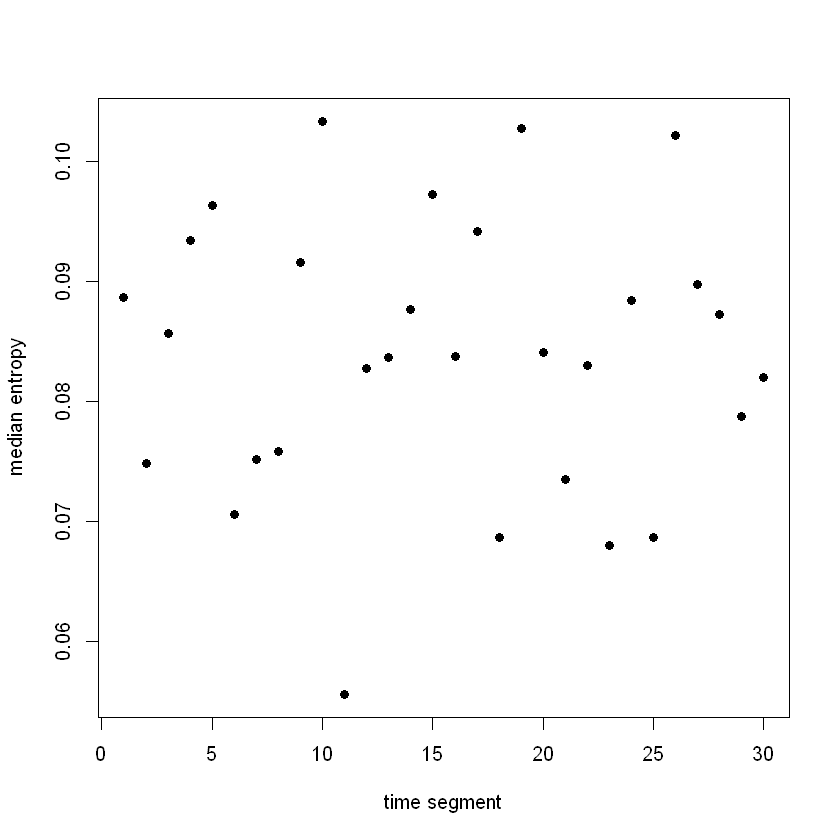

In [10]:
plot(t,et,xlab="time segment",ylab = "median entropy",pch=16)

In [11]:
entropyByLastChange <- function(a){
  #a is the result of getAllEntropies
  #here we save the entropy corresponding to the last change
  w <- vector()
  n <- dim(a$allEntropy)
  n <- n[1]
  
  for(i in 1:n[1]){
    w[i] <- a$allEntropy[i,a$indexlastchange[i]]
  }
  return(w)
  
}

In [12]:
elast <- entropyByLastChange(a)

In [13]:
PI <- matrix(data = c(pq$there,pq$reality,pq$place,pq$virtualplace),nrow=29,ncol=4)
PI_median <- apply(PI,1,median)

ERROR: Error in matrix(data = c(pq$there, pq$reality, pq$place, pq$virtualplace), : 'data' doit être de type vecteur, il était 'NULL'


In [ ]:
plot(PI_median,elast,xlab="PI_median",ylab="entropy",xlim=c(1,7), pch=16)

In [ ]:
PI_median2 <- PI_median^2
lm <- lm(elast ~ PI_median + PI_median2)
summary(lm)

cor.test(elast[PI_median>=3],PI_median[PI_median>=3])

In [ ]:
#Running 1000 times doesn't work on Kaggle, it takes too long.
#Instead I will illustrate it with 10 times.
#let's sample over the time periods and the number of states
#the total time is 20 minutes so let's sample randomly


e10 <- rep(0,29)
N <- 10
for(i in 1:N) {
  ntime <- round(runif(1,5,40))
  nstates <- round(runif(1,3,30))
  a <- getAllEntropies(ntime,nstates)
  e10 <- e10 + entropyByLastChange(a)
  cat("i = ",i," ","ntime = ",ntime,"nstates = ",nstates, "\n")
  flush.console()
}
e10 <- e10/N


In [ ]:
plot(PI_median,e10,xlim=c(1,7),ylab="median entropy", pch=16)


In [ ]:
#Stan analysis
library("rstan")
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

In [ ]:
mydata <- list(
            N = length(PI_median),
            pres = PI_median,
            entropy = e10
)


In [ ]:
stan_model <- "
data {
  int<lower=0> N;       // Number of data points
  vector[N] pres;       // Independent variable
  vector[N] entropy;    // Dependent variable
}

parameters {
  vector[3] b;                 
  real<lower=0> sigma;      
  real<lower=1> v;      //degrees of freedom
}

model {
  // Priors
  b ~ normal(0, 10);
  sigma ~ gamma(2,0.1);
  v ~ gamma(2,0.1);

  // Likelihood
  for(i in 1:N) {
      entropy[i] ~ student_t(v, b[1] + b[2]*pres[i] + b[3]*(pres[i]^2), sigma);
  }
}

generated quantities {
  vector[N] entropy_new;
  vector[N] log_lik_entropy;
  real m;
  
  for(i in 1:N){
    m = b[1] + b[2]*pres[i] + b[3]*(pres[i]^2);
    entropy_new[i] = student_t_rng(v,m, sigma);
    log_lik_entropy[i] = student_t_lpdf(entropy[i]|v,m, sigma);
  }
}
"

In [ ]:
fit <- stan (model_code = stan_model, # Stan program
              data = mydata, # named list of data
              chains = 4, # number of Markov chains
              iter = 3000, # total number of iterations per chain
              cores = 4,
              #control = list(max_treedepth = 12),
              seed=54321)


In [ ]:
print(fit, pars=c("b","sigma","v"),probs=c(.025,.975))

In [ ]:
e <- rstan::extract(fit)

In [ ]:
#probabilities of the parameters being positive
mean(e$b[,1]>0)
mean(e$b[,2]>0)
mean(e$b[,3]>0)

In [ ]:
#find the probability that the degrees of freedom might be less than 30
mean(e$v < 30)

In [ ]:
#obtain the means of the parameters forming the quadratic
b0 <- mean(e$b[,1])
b1 <- mean(e$b[,2])
b2 <- mean(e$b[,3])

In [ ]:
#now plot the quadratic over the data points
p <- seq(1,7,0.1)
ent <- b0 + b1*p + b2*(p^2)

In [ ]:
sz <- 1.5
plot(p, ent, type="l", ylim=c(1,3.5), xlim=c(1,7), xlab="", ylab="", 
     cex.lab=sz, cex.axis=sz)
par(new=TRUE)
plot(PI_median, e10, ylim=c(1,3.5), xlim=c(1,7), ylab="entropy", 
     pch=16, cex.lab=sz, cex.axis=sz)


In [ ]:
#plot observed against predicted posterior distribution means
plot(e10,apply(e$entropy_new,2,mean))
cor.test(e10,apply(e$entropy_new,2,mean))

In [ ]:
loo_summary <- function(fit, name) {

  log_lik <- extract_log_lik(fit, merge_chains = FALSE,parameter_name=name)
  r_eff <- relative_eff(exp(log_lik))
  loo <- loo(log_lik, r_eff = r_eff, cores = 2)
  return(loo)
}

In [ ]:
library("loo")
loo <- loo_summary(fit,"log_lik_entropy")
loo